## Setup

### Configure API keys

To fine-tune YOLO11, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

### Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Sun Jan 12 04:19:30 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLO8 via Ultralytics

In [ ]:
%pip install "ultralytics<=8.3.40" supervision roboflow

import ultralytics
ultralytics.checks()

Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.5/112.6 GB disk)


## Fine-tune YOLO8 on custom dataset

**NOTE:** When training YOLOv11, make sure your data is located in `datasets`. If you'd like to change the default location of the data you want to use for fine-tuning, you can do so through Ultralytics' `settings.json`. In this tutorial, we will use one of the [datasets](https://universe.roboflow.com/liangdianzhong/-qvdww) available on [Roboflow Universe](https://universe.roboflow.com/). When downloading, make sure to select the `yolov11` export format.

In [ ]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

from google.colab import userdata
from roboflow import Roboflow

ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
rf = Roboflow(api_key=ROBOFLOW_API_KEY)

workspace = rf.workspace("frc-tmglq")
project = workspace.project("frc-2025-algae-and-coral-djaal")
version = project.version(1)
dataset = version.download("yolov11")

/content/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to FRC-2025---Algae-and-Coral-1 in yolov11:: 100%|██████████| 3038/3038 [00:04<00:00, 704.23it/s] 


## Custom Training

In [ ]:
%cd {HOME}

# change epochs for further testing, have done up to 50 with decent results. Took me 30 minutes

!yolo task=detect mode=train model=yolov8n.pt data={dataset.location}/data.yaml epochs=50 imgsz=640 plots=True

/content
100% 6.25M/6.25M [00:00<00:00, 98.7MB/s]
New https://pypi.org/project/ultralytics/8.3.59 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/datasets/FRC-2025---Algae-and-Coral-1/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_n

**NOTE:** The results of the completed training are saved in `{HOME}/runs/detect/train/`. Let's examine them.

In [ ]:
!ls {HOME}/runs/detect/train/

args.yaml					    R_curve.png		 val_batch0_labels.jpg
confusion_matrix_normalized.png			    results.csv		 val_batch0_pred.jpg
confusion_matrix.png				    results.png		 val_batch1_labels.jpg
events.out.tfevents.1736655771.a6b55fa69814.1845.0  train_batch0.jpg	 val_batch1_pred.jpg
F1_curve.png					    train_batch1.jpg	 val_batch2_labels.jpg
labels_correlogram.jpg				    train_batch2.jpg	 val_batch2_pred.jpg
labels.jpg					    train_batch3440.jpg  weights
P_curve.png					    train_batch3441.jpg
PR_curve.png					    train_batch3442.jpg


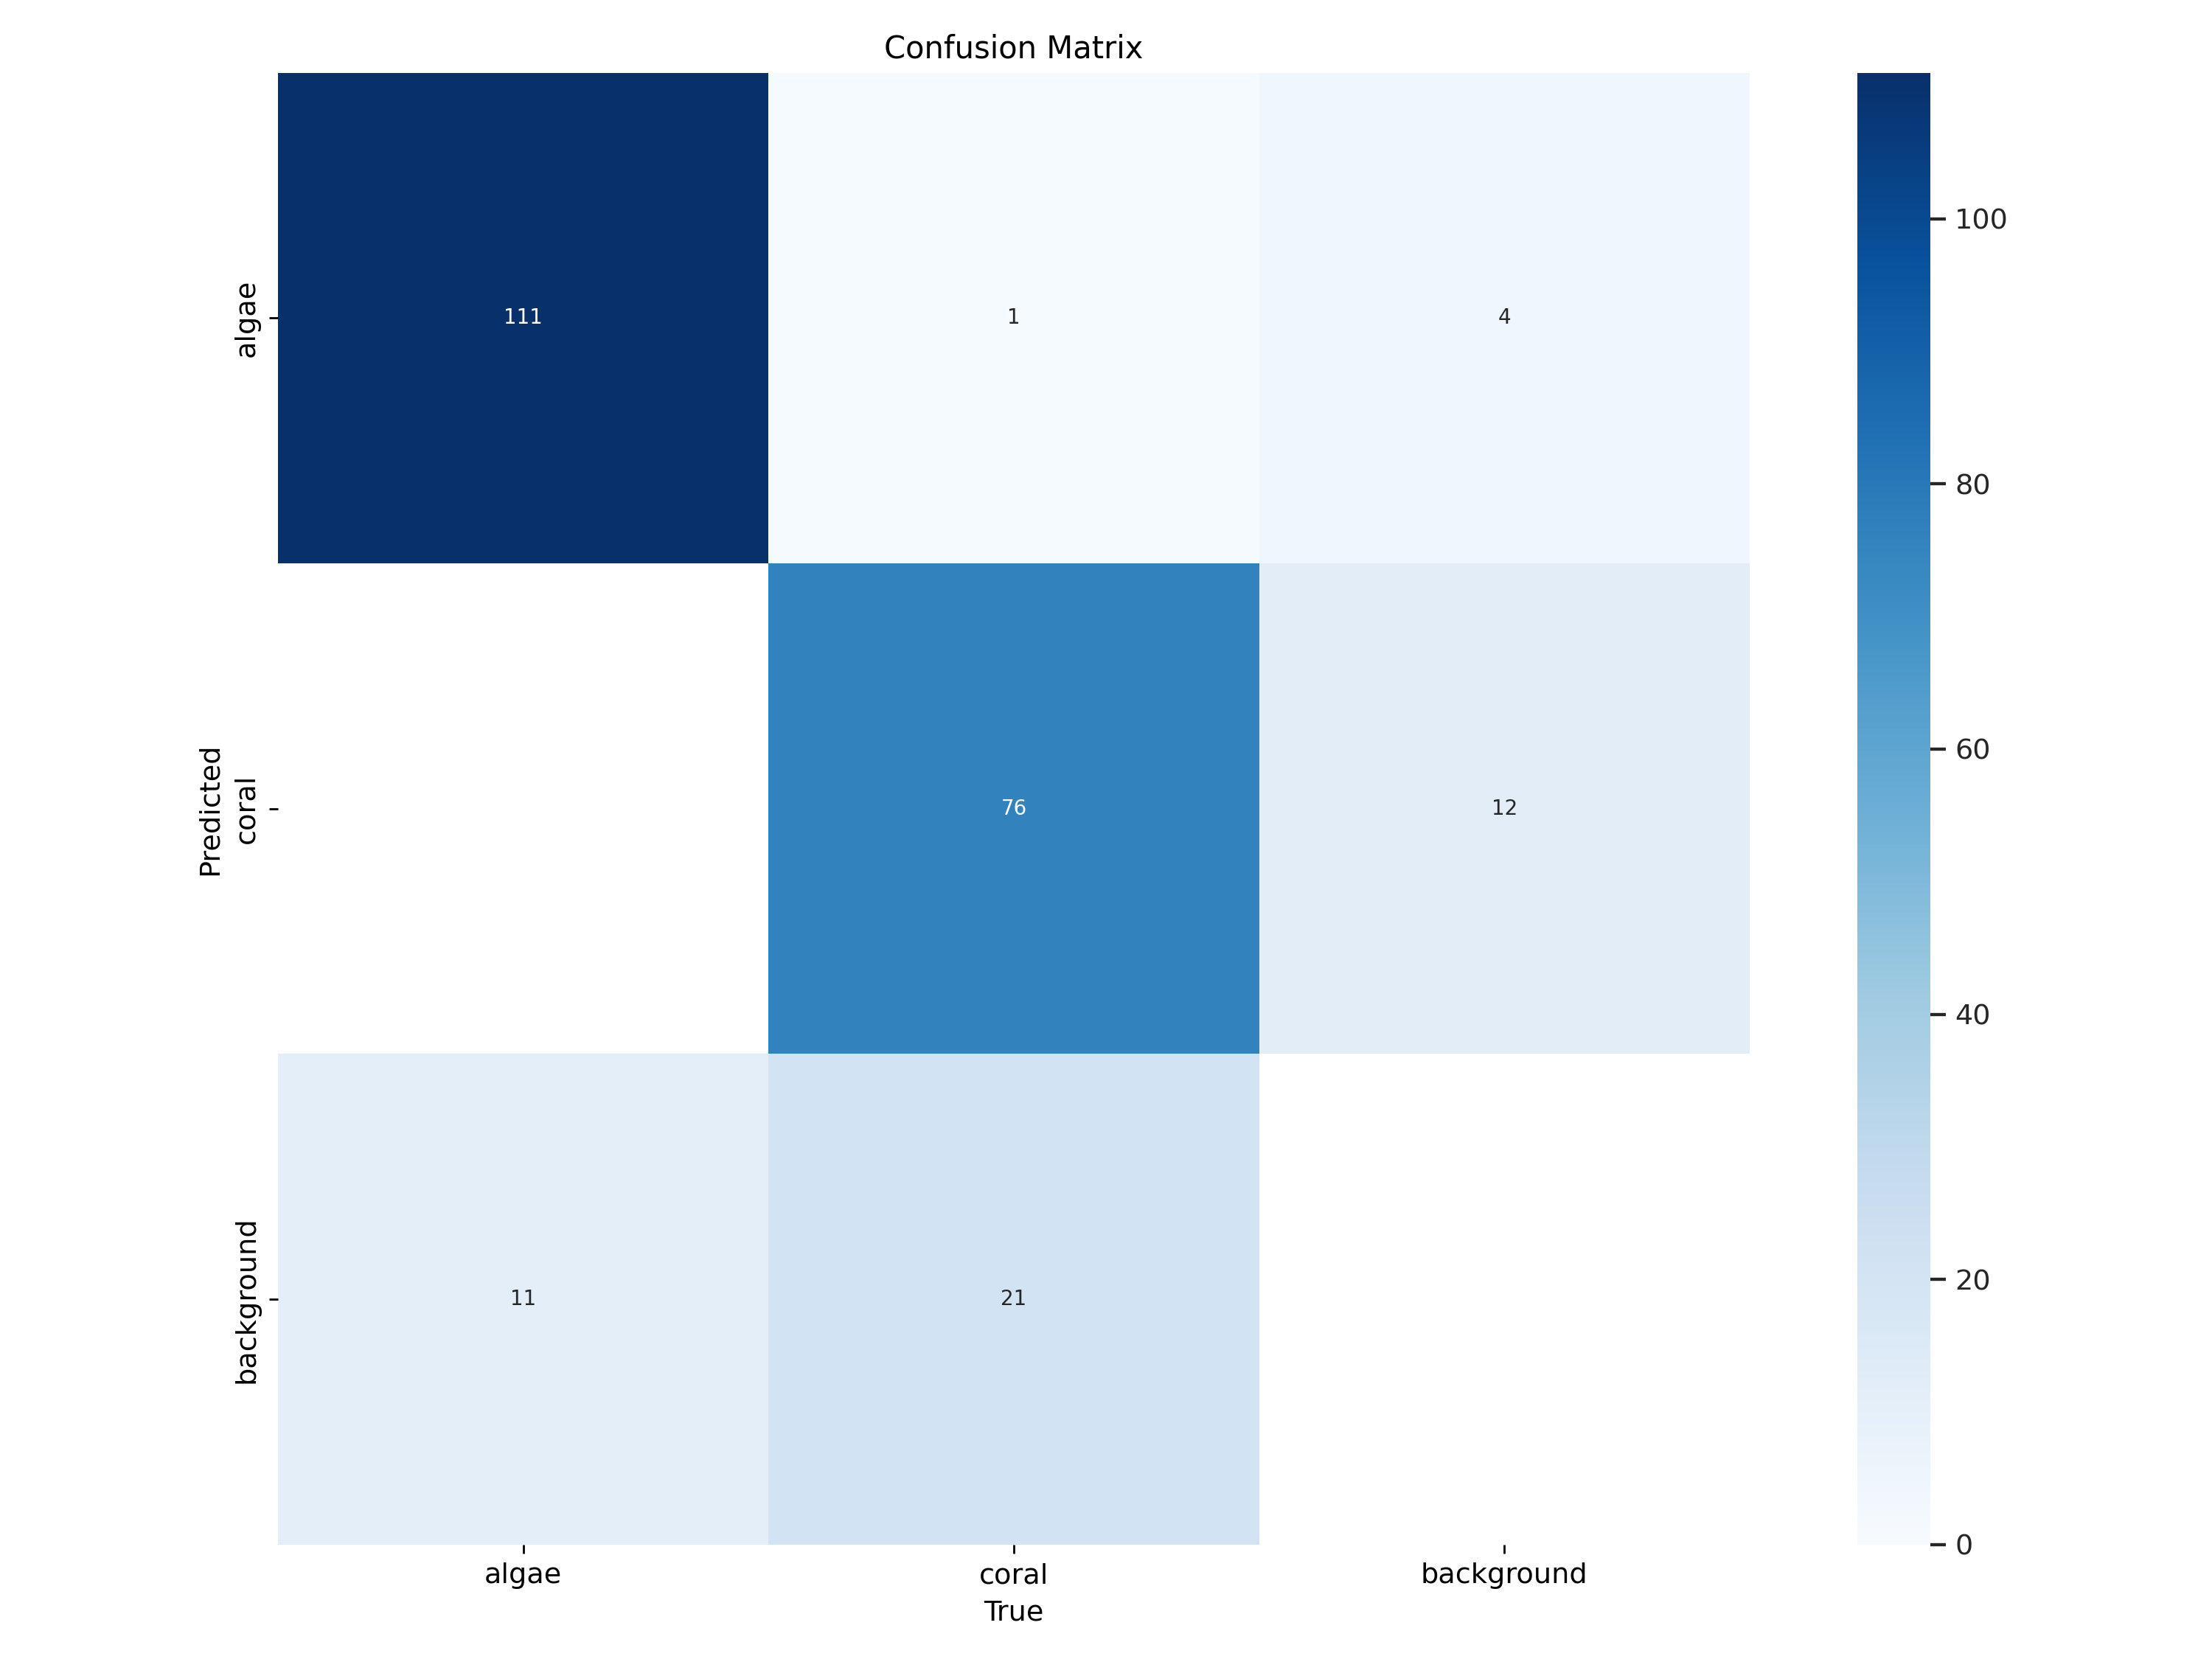

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

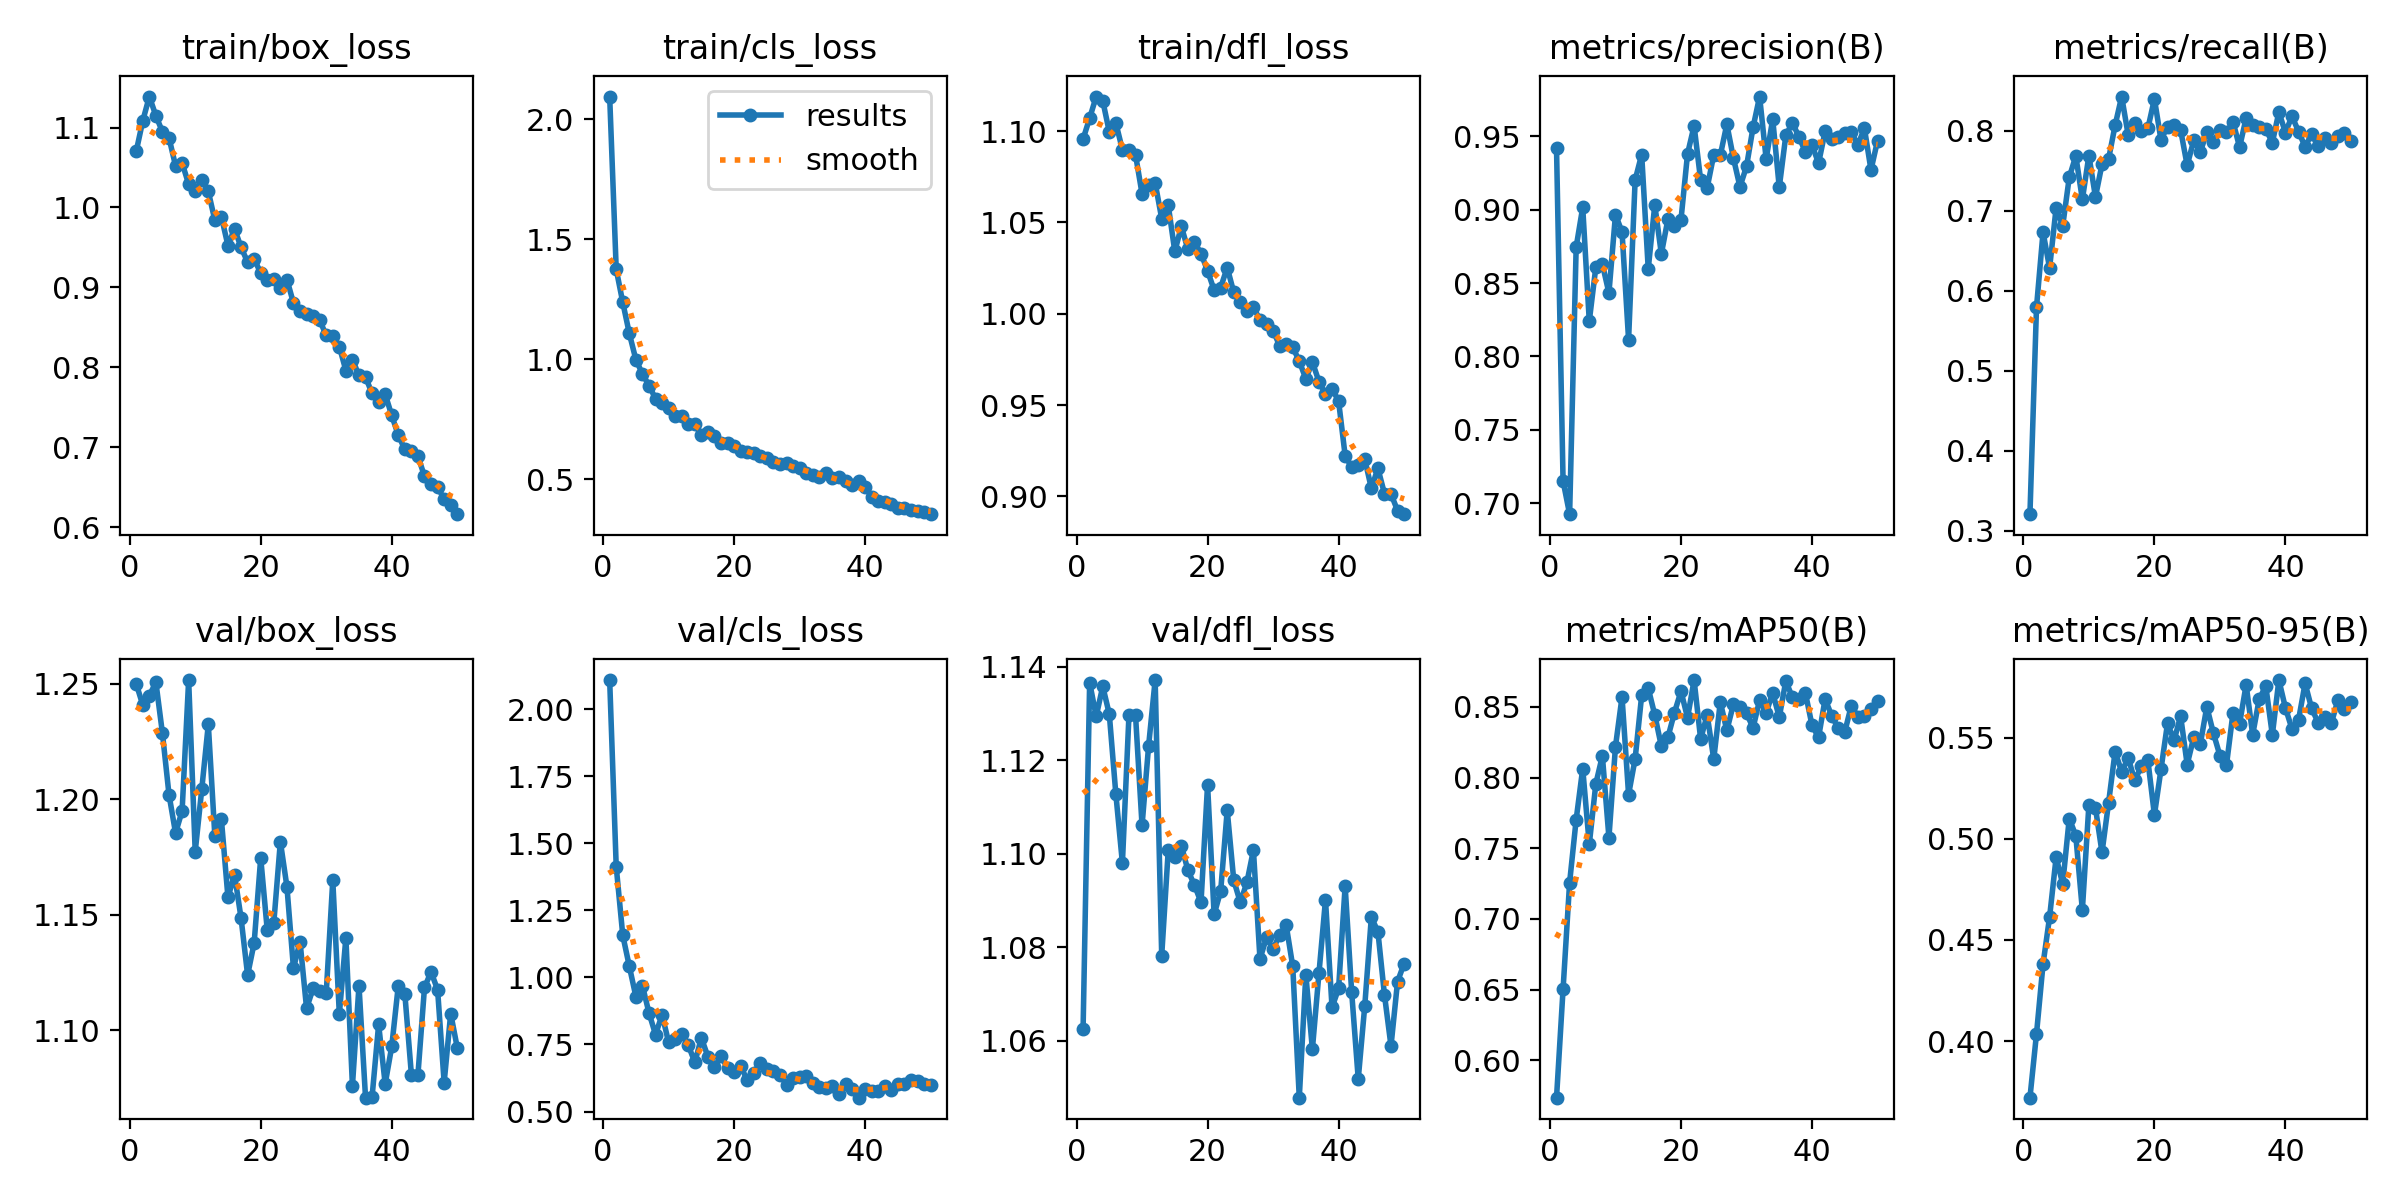

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/results.png', width=600)

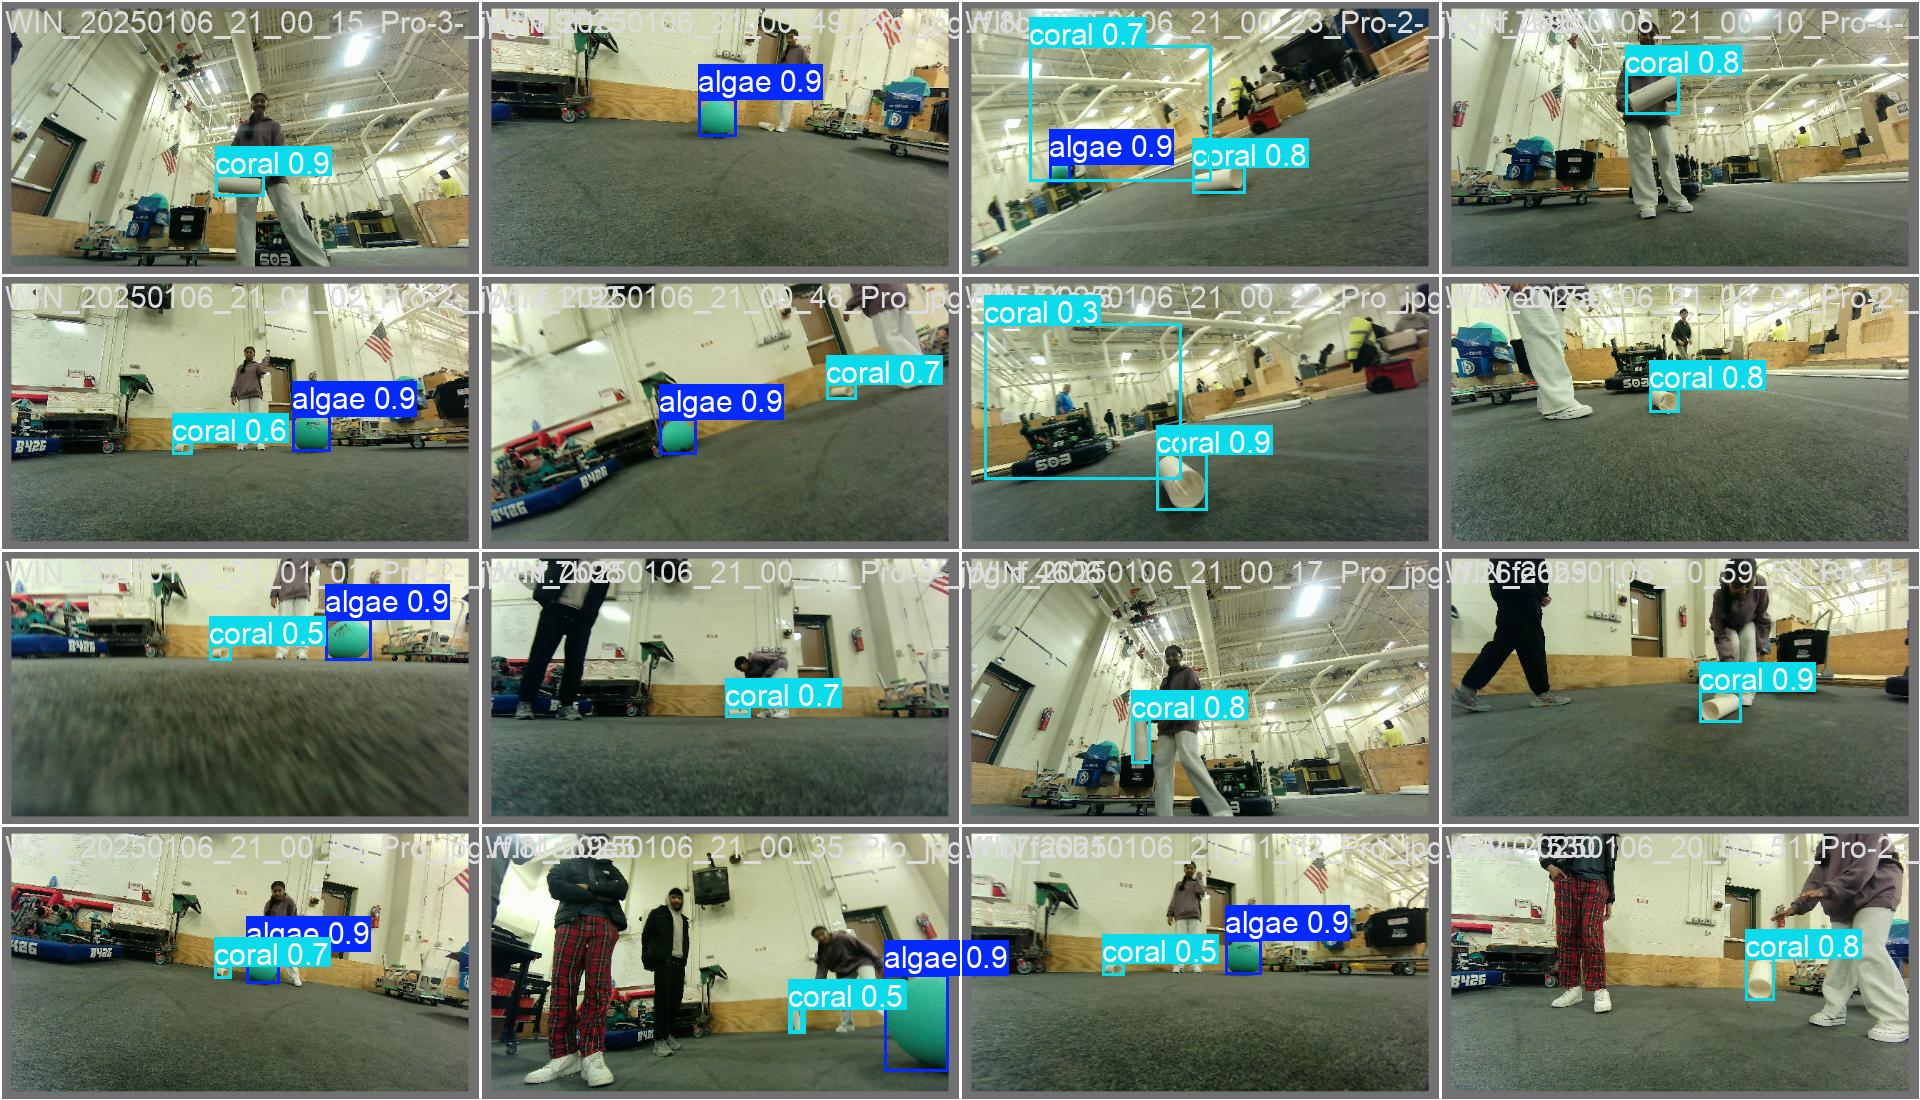

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

## Validate fine-tuned model

In [ ]:
!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /content/datasets/FRC-2025---Algae-and-Coral-1/valid/labels.cache... 94 images, 0 backgrounds, 0 corrupt: 100% 94/94 [00:00<?, ?it/s]
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 3, len(boxes) = 220. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 6/6 [00:02<00:00,  2.44it/s]
                   all         94        220      0.948      0.818      0.858      0.579
                 algae         68        122      0.998      0.902      0.923      0.681
                 coral         63         98      0.897      0.735      0.792      0.476
Speed: 2.1ms preprocess, 3.9

## Inference with custom model

In [ ]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs

image 1/48 /content/datasets/FRC-2025---Algae-and-Coral-1/test/images/FRC-2025-Kickoff-13_png.rf.2bf5d2e7006dd5c2fb78644258acc31c.jpg: 416x640 10 algaes, 2 corals, 45.8ms
image 2/48 /content/datasets/FRC-2025---Algae-and-Coral-1/test/images/FRC-2025-Kickoff-14_png.rf.a53bcac98d6df6943c361cc29f374479.jpg: 416x640 5 algaes, 6.4ms
image 3/48 /content/datasets/FRC-2025---Algae-and-Coral-1/test/images/FRC-2025-Kickoff-18_png.rf.d63ce45a26522ec3c83b75a760712020.jpg: 416x640 10 algaes, 11 corals, 6.3ms
image 4/48 /content/datasets/FRC-2025---Algae-and-Coral-1/test/images/FRC-2025-Kickoff-20_png.rf.52be13ee8e393e59ef0185acb2d946ee.jpg: 416x640 2 corals, 6.4ms
image 5/48 /content/datasets/FRC-2025---Algae-and-Coral-1/test/images/FRC-2025-Kickoff-32_png.rf.b6d6f1c133fe7980cdcc275660d2399b.jpg: 416x640 1 coral, 6.1ms
image 6/48 /conten

**NOTE:** Let's take a look at few results.

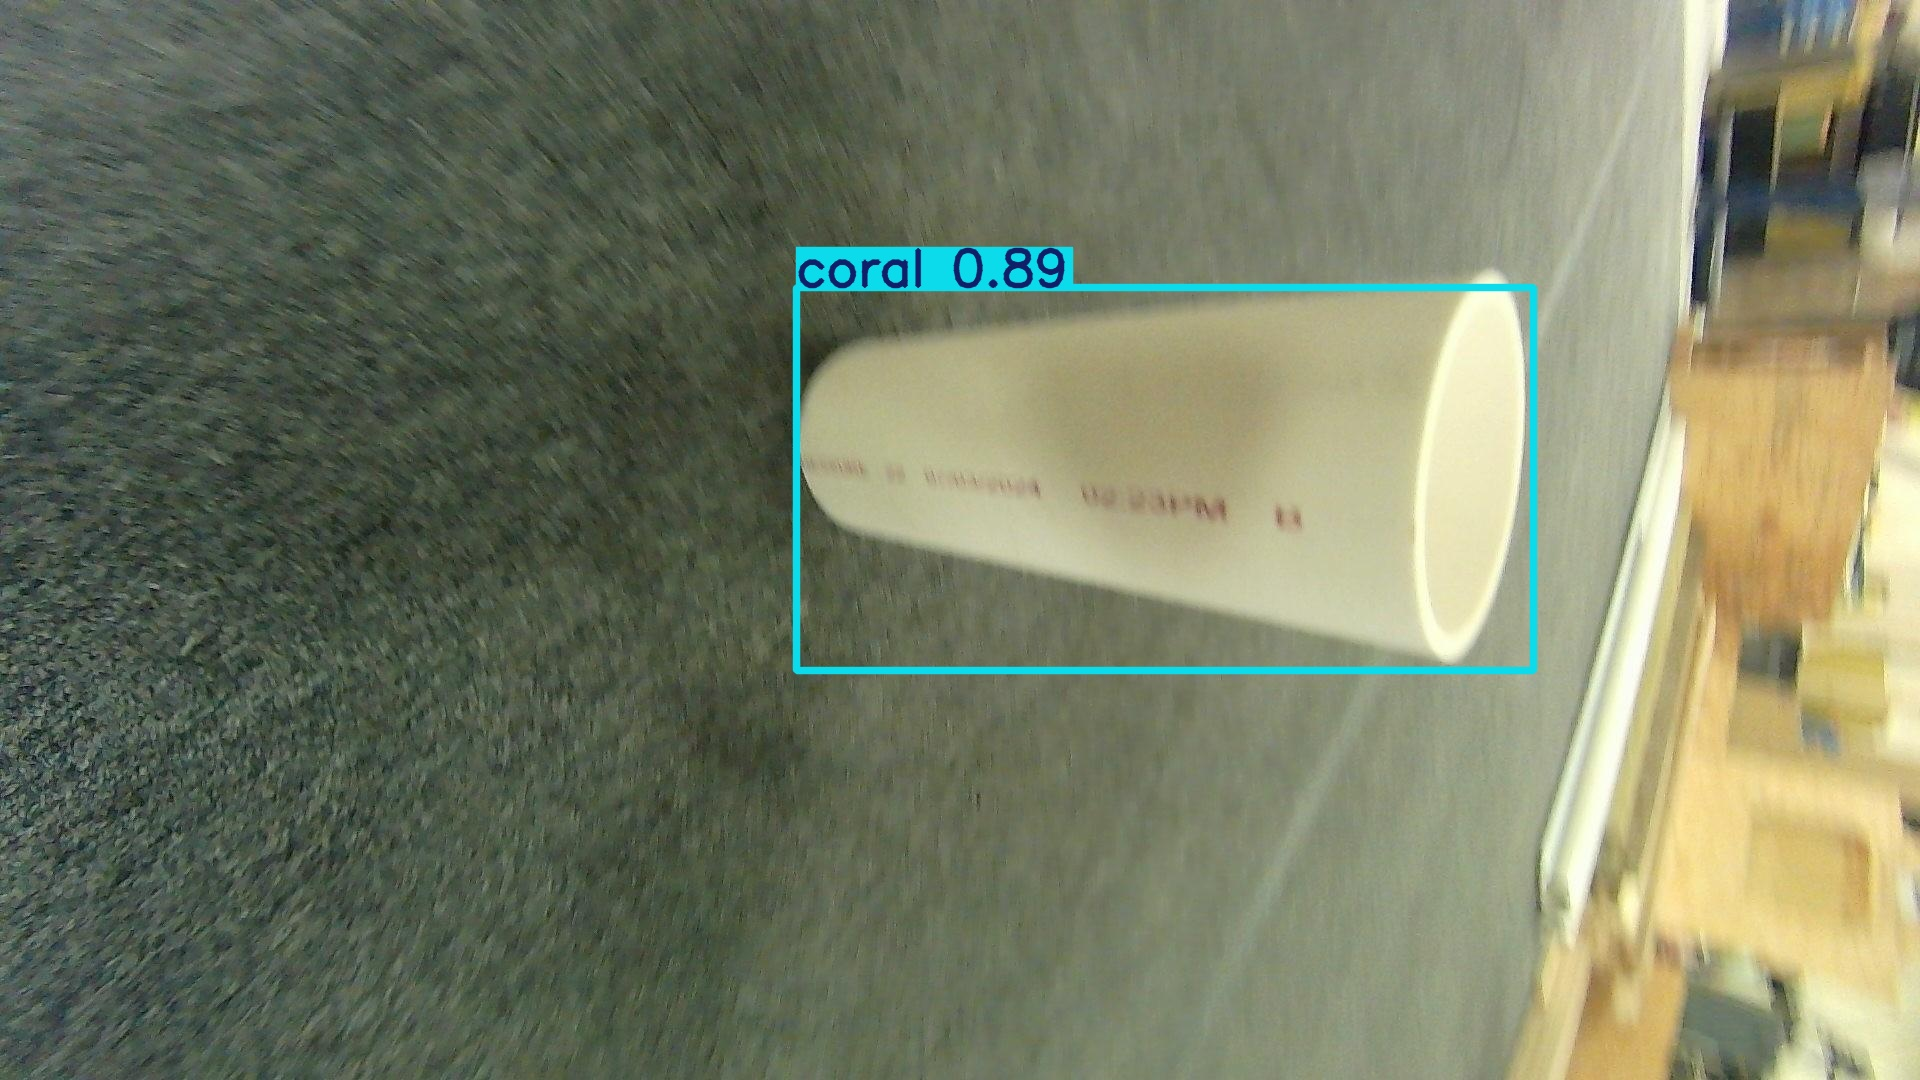

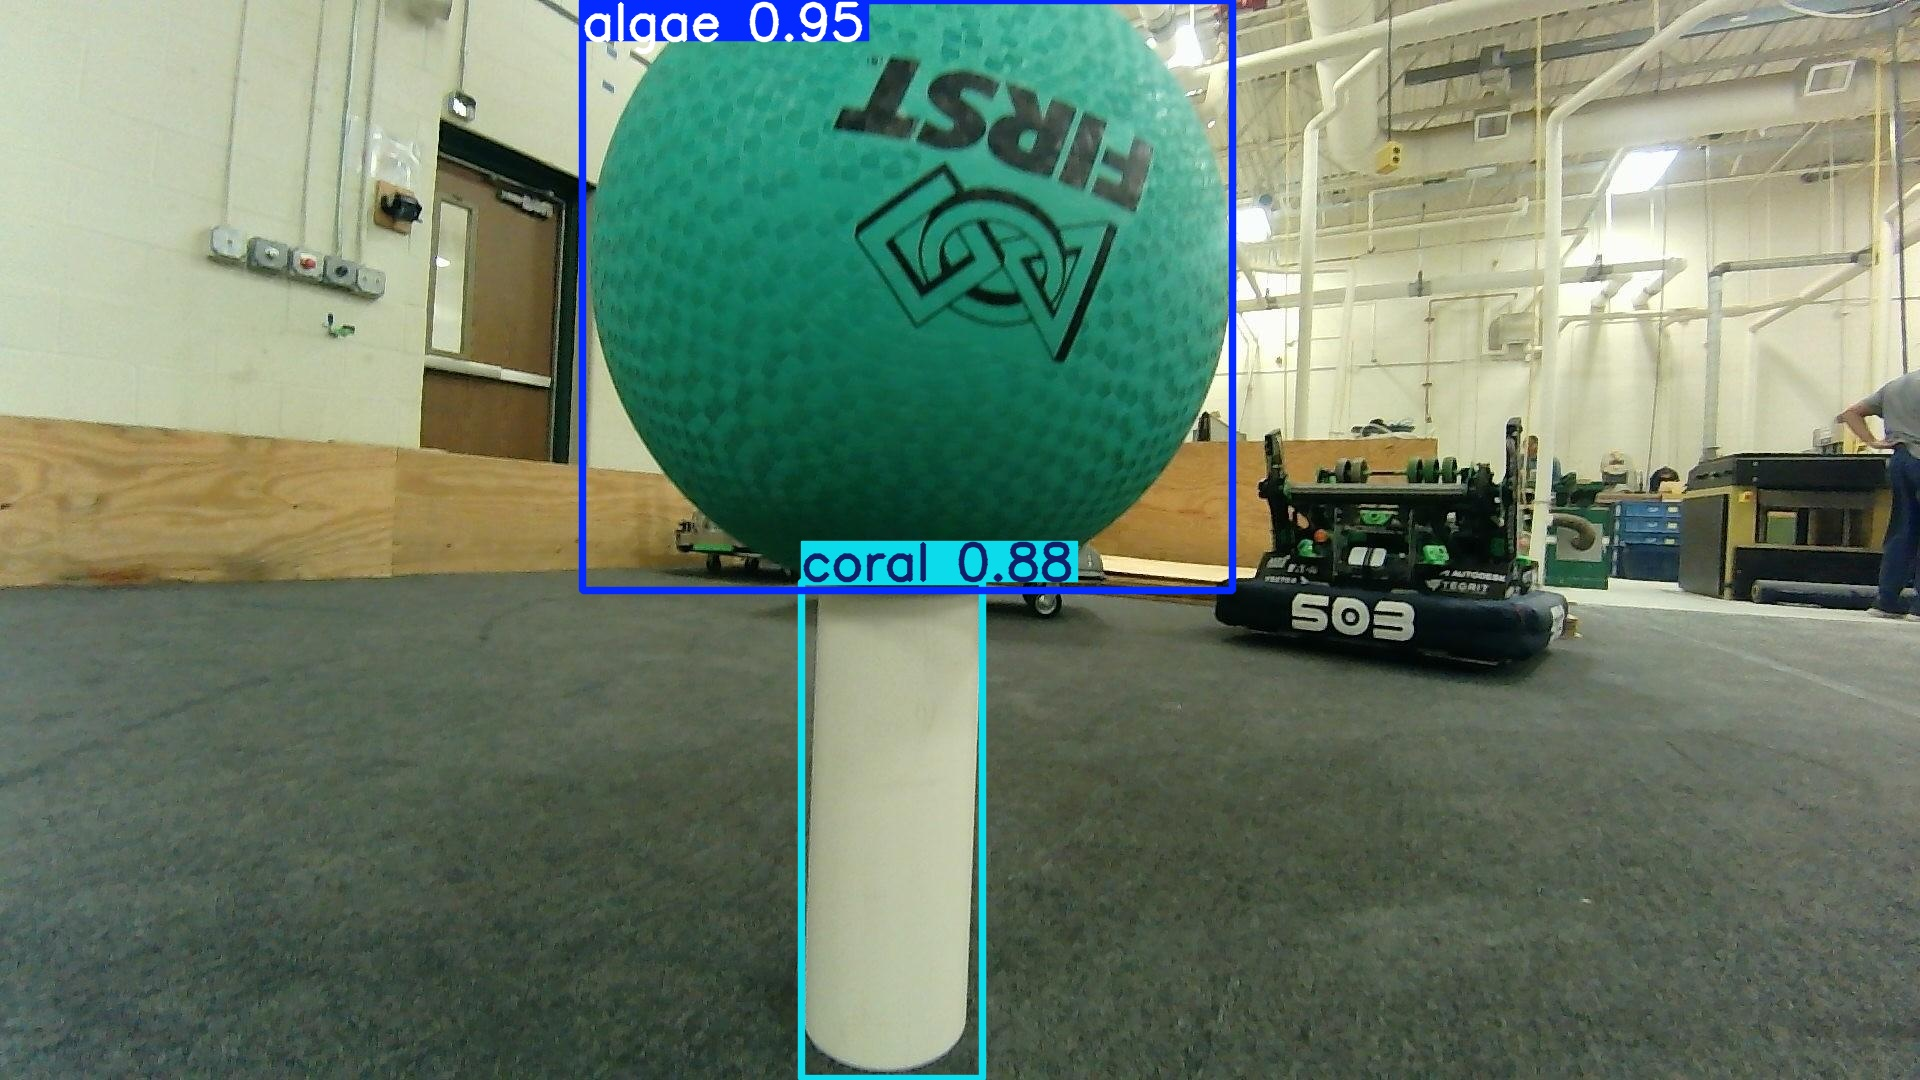

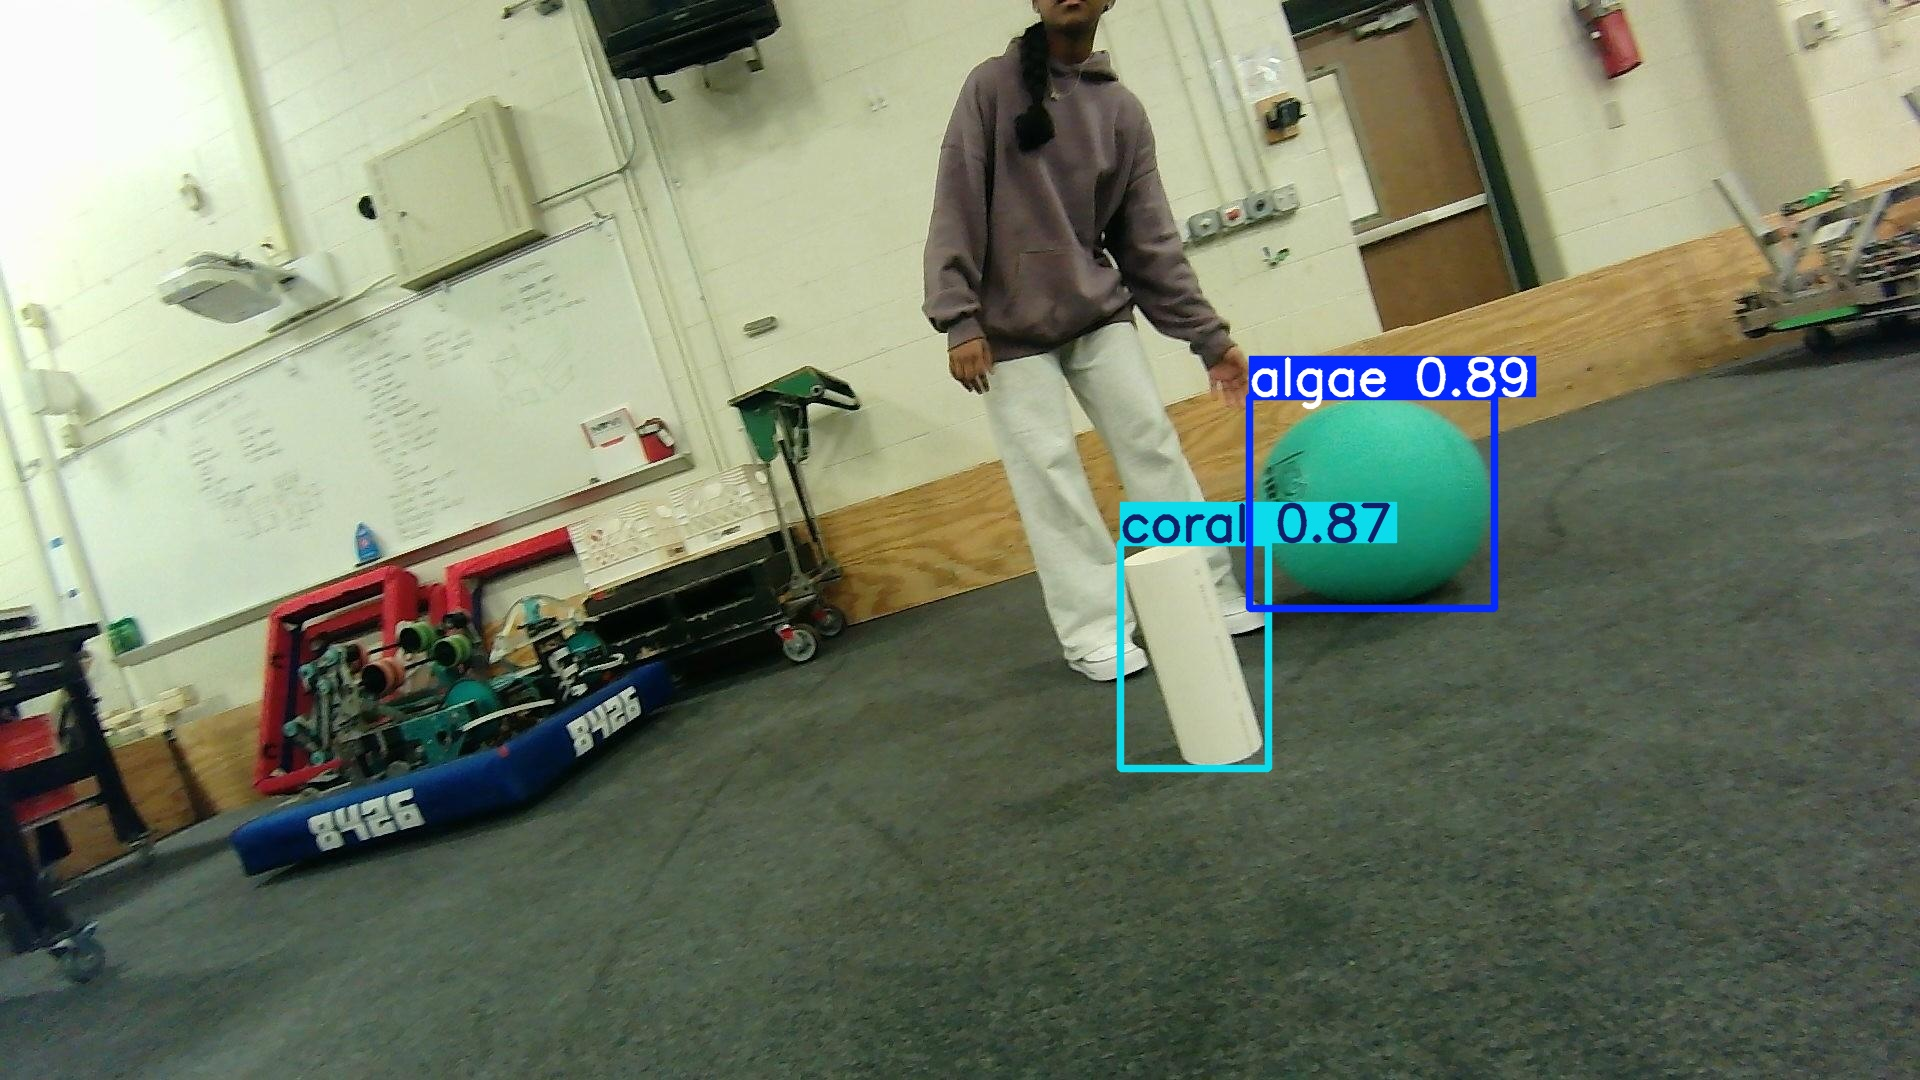

In [ ]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob(f'{HOME}/runs/detect/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=600))
    print("\n")

In [ ]:
from ultralytics import YOLO

model = YOLO("/content/runs/detect/train/weights/best.pt")  # load a custom trained model

# Export the model
model.export(format="edgetpu")

Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.00GHz)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from '/content/runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 6, 8400) (5.9 MB)
requirements: Ultralytics requirements ['sng4onnx>=1.0.1', 'onnx_graphsurgeon>=0.3.26', 'onnx>=1.12.0', 'onnx2tf>1.17.5,<=1.22.3', 'onnxslim>=0.1.31', 'tflite_support', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.6/136.6 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 kB 271.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 69.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 435.0/435.0 kB 324.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.8/142.8 kB 316.3 MB/s

100%|██████████| 1.11M/1.11M [00:00<00:00, 31.4MB/s]
Unzipping calibration_image_sample_data_20x128x128x3_float32.npy.zip to /content/calibration_image_sample_data_20x128x128x3_float32.npy...: 100%|██████████| 1/1 [00:00<00:00, 47.51file/s]


ONNX: starting export with onnx 1.17.0 opset 19...


ONNX: slimming with onnxslim 0.1.47...
ONNX: export success ✅ 1.2s, saved as '/content/runs/detect/train/weights/best.onnx' (11.8 MB)
TensorFlow SavedModel: starting TFLite export with onnx2tf 1.22.3...
TensorFlow SavedModel: export success ✅ 196.9s, saved as '/content/runs/detect/train/weights/best_saved_model' (39.2 MB)
Edge TPU: WARNING ⚠️ Edge TPU known bug https://github.com/ultralytics/ultralytics/issues/1185

Edge TPU: export requires Edge TPU compiler. Attempting install from https://coral.ai/docs/edgetpu/compiler/

Edge TPU: starting export with Edge TPU compiler 16.0.384591198...
Edge TPU: running 'edgetpu_compiler --out_dir "/content/runs/detect/train/weights/best_saved_model" --show_operations --search_delegate --delegate_search_step 30 --timeout_sec 180 "/content/runs/detect/train/weights/best_saved_model/best_full_integer_quant.tflite"'
Edge TPU: export success ✅ 16.2s, saved as '/content/runs/detect/train/weights/best_saved_model/best_full_integer_quant_edgetpu.tflite' (

'/content/runs/detect/train/weights/best_saved_model/best_full_integer_quant_edgetpu.tflite'

In [ ]:
! curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
! echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list
! sudo apt-get update
! sudo apt-get install edgetpu-compiler

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: apt-key is deprecated. Manage keyring files in trusted.gpg.d instead (see apt-key(8)).
100  1022  100  1022    0     0   6421      0 --:--:-- --:--:-- --:--:--  6427
OK
deb https://packages.cloud.google.com/apt coral-edgetpu-stable main
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 https://packages.cloud.google.com/apt coral-edgetpu-stable InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:8 http://archive.ubuntu.com/ub

In [ ]:
!cd /content/runs/detect/train/weights/best_saved_model && pwd && edgetpu_compiler best_int8.tflite && pwd && mv best_int8_edgetpu.tflite YOLO_neural_detector_coral.tflite && rm best_int8_edgetpu.log

/content/runs/detect/train/weights/best_saved_model
Edge TPU Compiler version 16.0.384591198
Started a compilation timeout timer of 180 seconds.

Model compiled successfully in 13 ms.

Input model: best_int8.tflite
Input size: 3.13MiB
Output model: best_int8_edgetpu.tflite
Output size: 3.12MiB
On-chip memory used for caching model parameters: 0.00B
On-chip memory remaining for caching model parameters: 0.00B
Off-chip memory used for streaming uncached model parameters: 0.00B
Number of Edge TPU subgraphs: 0
Total number of operations: 252
Operation log: best_int8_edgetpu.log

Model successfully compiled but not all operations are supported by the Edge TPU. A percentage of the model will instead run on the CPU, which is slower. If possible, consider updating your model to use only operations supported by the Edge TPU. For details, visit g.co/coral/model-reqs.
Number of operations that will run on Edge TPU: 0
Number of operations that will run on CPU: 252
See the operation log file for in